In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import requests
import io
import matplotlib.pyplot as plt
from dask.distributed import LocalCluster, Client
from xclim import sdba, indices
from xclim.sdba.detrending import LoessDetrend
from xarray.coding.calendar_ops import convert_calendar
from xclim.core.units import convert_units_to
from pathlib import Path

cmip6_dir = Path("/beegfs/CMIP6/arctic-cmip6/CMIP6")

Get requests for soil and air temp data at LTER2

In [2]:
# link for BC LTER 2 (floodplain) soil temp data
st_lter2_url = "https://www.lter.uaf.edu/php/download_data.php?f=/data_files/ascii/script_outputs/3_ST_LTER2_1988-2021.txt"
st_r = requests.get(st_lter2_url)

# temperature url
ta_lter2_url = "https://www.lter.uaf.edu/php/download_data.php?f=/data_files/ascii/script_outputs/1_AT_LTER2_1988-2021.txt"
at_r = requests.get(ta_lter2_url)

In [3]:
def convert_to_int(x):
    try:
        return int(x)
    except ValueError:
        if x == "Surface":
            return 0


st_df = pd.read_csv(
    io.StringIO(st_r.content.decode("utf8")),
    sep=",",
    usecols=["date", "tempC", "depth"],
    converters={"depth": convert_to_int},
    parse_dates=["date"],
)

st_df = (
    st_df.groupby(["date", "depth"])["tempC"]
    .agg(["min", "mean", "max"])
    .reset_index()
    .pivot(index="date", columns="depth", values=["min", "mean", "max"])
)

st_df.columns = ["_".join(("st", j, str(k))) for j, k in st_df.columns]

In [4]:
at_df = pd.read_csv(
    io.StringIO(at_r.content.decode("utf8")),
    usecols=["date", "airtemp", "airtemp_max", "airtemp_min", "height"],
    parse_dates=["date"],
)

df1, df2, df3 = [
    at_df.groupby(["date", "height"])["airtemp_max"].agg("max").reset_index(),
    at_df.groupby(["date", "height"])["airtemp"].agg("mean").reset_index(),
    at_df.groupby(["date", "height"])["airtemp_min"].agg("min").reset_index(),
]

keys = ["date", "height"]

at_df = pd.merge(pd.merge(df1, df2, on=keys), df3, on=keys).pivot(
    index="date", columns="height", values=["airtemp_max", "airtemp", "airtemp_min"]
)


at_df.columns = ["_".join((j, str(k))) for j, k in at_df.columns]
at_df

,airtemp_max_50,airtemp_max_150,airtemp_50,airtemp_150,airtemp_min_50,airtemp_min_150
date,,,,,,
1988-06-02,NaN,18.100,NaN,12.154545,NaN,8.00
1988-06-03,NaN,22.500,NaN,13.945833,NaN,7.40
1988-06-04,NaN,24.100,NaN,15.529167,NaN,4.20
1988-06-05,NaN,28.000,NaN,16.362500,NaN,3.60
1988-06-06,NaN,18.600,NaN,13.537500,NaN,10.50
...,...,...,...,...,...,...
2021-12-27,0.728,2.801,-3.513792,-5.752833,-7.604,-12.54
2021-12-28,-3.904,0.801,-5.082375,-6.570625,-6.957,-9.97
2021-12-29,-2.337,0.784,-2.904958,-5.258458,-4.112,-10.36


In [5]:
# merge the two dataframes
ref_ds = pd.merge(
    st_df,
    at_df,
    on=["date"],
).to_xarray()

Okay let's try bias-adjusting the soil temperatures. Both datasets have mean temperature at 5 cm, so let's start with that. 

Subset to the grid cell intersected by the LTER site and pull data at 5 cm depth. Also subset the data temporally, to a window of 1995-01-01 - 2014-12-31, plus the preceding and following 15 days (for a 31-day grouping window).

In [6]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

In [6]:
# all files have date strings of format "YYYYMMDD-YYYYMMDD". Use this info to choose the files that cover a given time period
def get_files_for_period(files, start_date, end_date):
    def parse_date(f, which):
        which_lu = {"start": 0, "end": 1}
        return int(f.name.split(".")[0].split("_")[-1].split("-")[which_lu[which]])

    fps = [
        f
        for f in files
        if not (
            (parse_date(f, "end") < start_date) or (parse_date(f, "start") > end_date)
        )
    ]
    return sorted(fps)


def get_sim_fps(cmip6_dir, model, scenario, start_date, end_date):
    all_fps = list(
        cmip6_dir.glob(f"ScenarioMIP/*/{model}/{scenario}/*/Eday/tsl/*/*/tsl_Eday*.nc")
    )
    return get_files_for_period(all_fps, start_date, end_date)


def get_hist_fps(cmip6_dir, model, start_date, end_date):
    all_fps = list(
        cmip6_dir.glob(f"CMIP/*/{model}/historical/*/Eday/tsl/*/*/tsl_Eday*.nc")
    )
    return get_files_for_period(all_fps, start_date, end_date)

In [7]:
# prep reference data
# aren't combining historical + scenario data to get the extra 15 days for bc yet
ref_start_date = "1994-12-17"
ref_end_date = "2014-12-30"
ref_time_slice = slice(ref_start_date, ref_end_date)
ref = ref_ds["st_mean_5"].sel(date=ref_time_slice).rename({"date": "time"})
ref.attrs["units"] = "degC"
ref = convert_calendar(ref, "noleap", align_on="date")

In [94]:
from multiprocessing import Pool


def open_and_extract(fp, sel_di):
    "open and extract by sel_di from a single file"
    with xr.open_dataset(fp, engine="h5netcdf") as ds:
        da = ds["tsl"].sel(sel_di, method="nearest")

    return da


def extract_across_files(fps, sel_di, ncpus=16):
    "extract across files"
    with Pool(ncpus) as pool:
        das = pool.starmap(open_and_extract, [(fp, sel_di) for fp in fps])

    da = xr.concat(das, dim="time")
    da = convert_units_to(da, "degC")
    da = convert_calendar(da, "noleap", align_on="date")
    # some models have hour values of 0 instead of 12. Just shifting those to make them consistent
    if da.time[0].dt.hour == 0:
        da["time"] = xr.CFTimeIndex.shift(da.time, periods=12, freq="h")

    # drop these variables as they are not consistent across models
    da = da.drop_vars(["depth", "lat", "lon"])

    return da

In [9]:
# # no historical files will have 2015 so we will cross that bridge if we need to
# model = "HadGEM3-GC31-LL"
# hist_fps = get_hist_fps(cmip6_dir, model, 19971217, 20141231)

# if len(hist_fps) == 0:
#     raise ValueError(f"No historical files found for {model}")

# hist_ds = xr.open_mfdataset(hist_fps)

# # hist_ds = xr.open_mfdataset(
# #     [
# #         "/beegfs/CMIP6/arctic-cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/Eday/tsl/gn/v20190624/tsl_Eday_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19900101-19991230.nc",
# #         "/beegfs/CMIP6/arctic-cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/Eday/tsl/gn/v20190624/tsl_Eday_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_20000101-20091230.nc",
# #         "/beegfs/CMIP6/arctic-cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/Eday/tsl/gn/v20190624/tsl_Eday_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_20100101-20141230.nc",
# #     ]
# # )

# # lat and lon of the BC LTER 2 site
# lon = -148.2549125
# lat = 64.69889576
# # depth of the soil temperature measurements we want
# depth = 0.05
# sel_di = {"lat": lat, "lon": lon + 180, "depth": depth}

# hist = hist_ds.sel(sel_di, method="nearest").sel(time=ref_time_slice)["tsl"].chunk({"time": -1})

# # probably won't matter much, but align the calendars for consistency
# hist = convert_calendar(hist, "noleap", align_on="date")

# kind = "+"

# train_kwargs = dict(
#     ref=ref,
#     hist=hist,
#     nquantiles=50,
#     group="time.dayofyear",
#     window=31,
#     kind=kind,
# )

# dqm = sdba.DetrendedQuantileMapping.train(**train_kwargs)

# # Create the detrending object
# det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")

# hist_adj = (
#     dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)
#     # in testing, adjusted outputs are oriented lat, lon, time for some reason
# )

lon = -148.2549125
lat = 64.69889576
depth = 0.05
sel_di = {"lat": lat, "lon": lon + 180, "depth": depth}


# this function preprocesses the data by simply selecting the nearest lat, lon, and depth in sel_di
# it seems to really help with the performance of open_mfdataset
def preprocess(ds):
    return ds.sel(sel_di, method="nearest")


def train_hist_adj(
    ref,
    cmip6_dir,
    model,
    det,
):
    hist_fps = get_hist_fps(
        cmip6_dir,
        model,
        int(ref.time.values[0].strftime("%Y%m%d")),
        int(ref.time.values[-1].strftime("%Y%m%d")),
    )

    if len(hist_fps) == 0:
        print(f"No historical files found for {model}")
        return None, None

    hist_ds = xr.open_mfdataset(hist_fps, parallel=True, preprocess=preprocess).load()
    hist = hist_ds.sel(time=ref_time_slice)["tsl"]
    hist = convert_units_to(hist, "degC")
    hist = convert_calendar(hist, "noleap", align_on="date")

    kind = "+"
    train_kwargs = dict(
        ref=ref,
        hist=hist,
        nquantiles=50,
        group="time.dayofyear",
        window=31,
        kind=kind,
    )

    dqm = sdba.DetrendedQuantileMapping.train(**train_kwargs)

    hist_adj = (
        (
            dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)
            # in testing, adjusted outputs are oriented lat, lon, time for some reason
        )
        .rename("tsl")
        .assign_coords({"model": model, "scenario": "historical"})
        .expand_dims(["model", "scenario"])
    )

    return dqm, hist_adj


def adjust_sim(dqm, cmip6_dir, model, scenario, det):
    start_date, end_date = "2015-01-01", "2099-12-30"
    sim_fps = get_sim_fps(
        cmip6_dir,
        model,
        scenario,
        int(start_date.replace("-", "")),
        int(end_date.replace("-", "")),
    )

    if len(sim_fps) == 0:
        print(f"No scenario files found for {model} {scenario}")
        return None, None

    sim_ds = xr.open_mfdataset(sim_fps, parallel=True, preprocess=preprocess).load()
    sim = sim_ds.sel(time=slice(start_date, end_date))["tsl"]
    sim = convert_units_to(sim, "degC")
    sim = convert_calendar(sim, "noleap", align_on="date")

    sim_adj = (
        (
            dqm.adjust(sim, extrapolation="constant", interp="nearest", detrend=det)
            # in testing, adjusted outputs are oriented lat, lon, time for some reason
        )
        .rename("tsl")
        .assign_coords({"model": model, "scenario": scenario})
        .expand_dims(["model", "scenario"])
    )

    return sim, sim_adj


models = [
    # those without historical tsl are commented out
    # "GFDL-ESM4",
    # "KACE-1-0-G",
    # "CNRM-CM6-1-HR",
    "NorESM2-MM",
    # "TaiESM1",
    "HadGEM3-GC31-MM",
    "HadGEM3-GC31-LL",
    "MIROC6",  # available under 6hrPlevPt
    # "EC-Earth3-Veg",
    "CESM2",
    "MPI-ESM1-2-HR",  # avialable under 6hrPlevPt
    # "MRI-ESM2-0",
]

# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")

dqm_lu = {}
sim_das = []
adj_das = []

In [11]:
lon = -148.2549125
lat = 64.69889576
depth = 0.05
sel_di = {"lat": lat, "lon": lon + 180, "depth": depth}


def train_hist_adj(
    ref,
    cmip6_dir,
    model,
    det,
):
    hist_fps = get_hist_fps(
        cmip6_dir,
        model,
        int(ref.time.values[0].strftime("%Y%m%d")),
        int(ref.time.values[-1].strftime("%Y%m%d")),
    )

    if len(hist_fps) == 0:
        print(f"No historical files found for {model}")
        return None, None

    hist = extract_across_files(hist_fps, sel_di).sel(time=ref_time_slice)

    kind = "+"
    train_kwargs = dict(
        ref=ref,
        hist=hist,
        nquantiles=50,
        group="time.dayofyear",
        window=31,
        kind=kind,
    )

    dqm = sdba.DetrendedQuantileMapping.train(**train_kwargs)

    hist_adj = (
        (
            dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)
            # in testing, adjusted outputs are oriented lat, lon, time for some reason
        )
        .rename("tsl")
        .assign_coords({"model": model, "scenario": "historical"})
        .expand_dims(["model", "scenario"])
    )

    return dqm, hist_adj


def adjust_sim(dqm, cmip6_dir, model, scenario, det):
    start_date, end_date = "2015-01-01", "2099-12-30"
    sim_fps = get_sim_fps(
        cmip6_dir,
        model,
        scenario,
        int(start_date.replace("-", "")),
        int(end_date.replace("-", "")),
    )

    if len(sim_fps) == 0:
        print(f"No scenario files found for {model} {scenario}")
        return None, None

    sim = extract_across_files(sim_fps, sel_di).sel(time=slice(start_date, end_date))

    sim_adj = (
        (
            dqm.adjust(sim, extrapolation="constant", interp="nearest", detrend=det)
            # in testing, adjusted outputs are oriented lat, lon, time for some reason
        )
        .rename("tsl")
        .assign_coords({"model": model, "scenario": scenario})
        .expand_dims(["model", "scenario"])
    )

    return sim, sim_adj


models = [
    # those without historical tsl are commented out
    # "GFDL-ESM4",
    # "KACE-1-0-G",
    # "CNRM-CM6-1-HR",
    "NorESM2-MM",
    # "TaiESM1",
    "HadGEM3-GC31-MM",
    "HadGEM3-GC31-LL",
    "MIROC6",  # available under 6hrPlevPt
    # "EC-Earth3-Veg",
    "CESM2",
    "MPI-ESM1-2-HR",  # avialable under 6hrPlevPt
    # "MRI-ESM2-0",
]

# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")

dqm_lu = {}
sim_das = []
adj_das = []

In [ ]:
model = "HadGEM3-GC31-LL"
hist_fps = get_hist_fps(
    cmip6_dir,
    model,
    int(ref.time.values[0].strftime("%Y%m%d")),
    int(ref.time.values[-1].strftime("%Y%m%d")),
)

In [ ]:
test = extract_across_files(hist_fps, sel_di)

In [12]:
for model in ["NorESM2-MM", "HadGEM3-GC31-MM", "HadGEM3-GC31-LL", "CESM2"]:
    dqm, hist_adj = train_hist_adj(
        ref,
        cmip6_dir,
        model,
        det,
    )

    dqm_lu[model] = dqm
    adj_das.append(hist_adj)
    print(f"Finished {model} historical")

    for scenario in ["ssp245", "ssp370", "ssp585"]:
        sim, adj = adjust_sim(dqm, cmip6_dir, model, scenario, det)
        adj_das.append(adj)
        sim_das.append(sim)
        print(f"Finished {model} {scenario}")

Finished NorESM2-MM historical
Finished NorESM2-MM ssp245
Finished NorESM2-MM ssp370
Finished NorESM2-MM ssp585
Finished HadGEM3-GC31-MM historical
No scenario files found for HadGEM3-GC31-MM ssp245
Finished HadGEM3-GC31-MM ssp245
No scenario files found for HadGEM3-GC31-MM ssp370
Finished HadGEM3-GC31-MM ssp370
Finished HadGEM3-GC31-MM ssp585
Finished HadGEM3-GC31-LL historical
Finished HadGEM3-GC31-LL ssp245
No scenario files found for HadGEM3-GC31-LL ssp370
Finished HadGEM3-GC31-LL ssp370
Finished HadGEM3-GC31-LL ssp585


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Finished CESM2 historical


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Finished CESM2 ssp245


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Finished CESM2 ssp370


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Finished CESM2 ssp585


In [62]:
adj_das = [da for da in adj_das if da is not None]

In [115]:
for da in adj_das:
    if da.time.dt.hour.values[0] == 0:
        da["time"] = xr.CFTimeIndex.shift(da.time, periods=12, freq="h")

In [122]:
adj_das = [da.drop_vars(["lat", "lon"]) for da in adj_das]

In [139]:
adj_ds = xr.merge(adj_das)

# add decade coordinate for grouping
year = adj_ds.time.dt.year
# get decade from the year

adj_ds

<xarray.Dataset> Size: 8MB
Dimensions:   (time: 38338, model: 4, scenario: 4)
Coordinates:
  * time      (time) object 307kB 1994-12-17 12:00:00 ... 2099-12-30 12:00:00
  * model     (model) <U15 240B 'CESM2' 'HadGEM3-GC31-LL' ... 'NorESM2-MM'
  * scenario  (scenario) <U10 160B 'historical' 'ssp245' 'ssp370' 'ssp585'
    decade    (time) <U21 3MB '1990' '1990' '1990' ... '2090' '2090' '2090'
Data variables:
    tsl       (model, scenario, time) float64 5MB -5.181 -5.168 ... 0.9653
Attributes:
    standard_name:    soil_temperature
    long_name:        Temperature of Soil
    comment:          Temperature of soil. Reported as missing for grid cells...
    units:            degC
    original_name:    TSOI
    cell_methods:     area: mean where land time: mean
    cell_measures:    area: areacella
    history:          2019-12-02T02:18:39Z altered by CMOR: Converted type fr...
    units_metadata:   temperature: unknown
    bias_adjustment:  DetrendedQuantileMapping(group=Grouper(name='time.dayof...

In [225]:
ffss = indices.frost_free_season_start(adj_ds["tsl"].sel(time=slice("2020", "2100")))


def assign_decade(da):
    year = da.time.dt.year
    decade = (year // 10) * 10
    return da.assign_coords({"decade": decade})


ffss = assign_decade(ffss)

In [227]:
def assign_twenty_year_period(da):
    year = da.time.dt.year
    twodecade = (year // 20) * 20
    return da.assign_coords({"twodecade": twodecade})


ffss = assign_twenty_year_period(ffss)

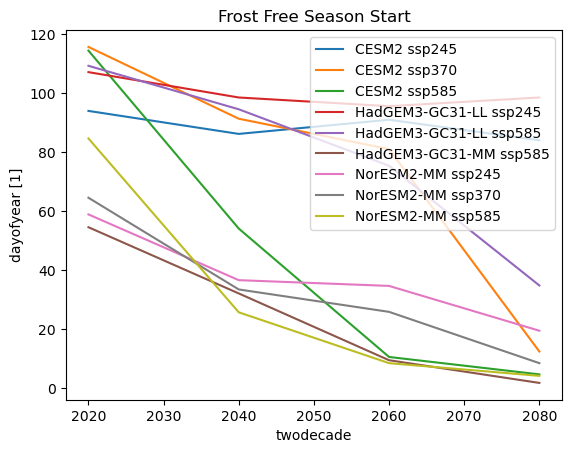

In [234]:
for model in ffss.model.values:
    for scenario in ffss.scenario.values:
        tmp = ffss.sel(model=model, scenario=scenario)
        if np.all(np.isnan(tmp)):
            continue
        tmp.groupby("twodecade").mean().plot(x="twodecade", label=f"{model} {scenario}")

plt.title("Frost Free Season Start")
plt.legend()

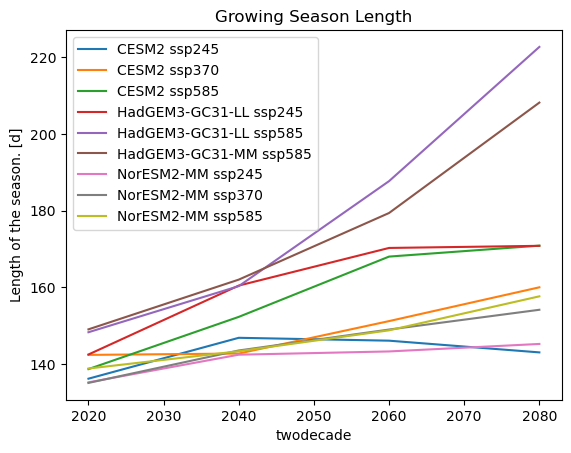

In [247]:
gsl = indices.growing_season_length(adj_ds["tsl"].sel(time=slice("2020", "2100")))
# plot like above
gsl = assign_twenty_year_period(gsl)

for model in gsl.model.values:
    for scenario in gsl.scenario.values:
        tmp = gsl.sel(model=model, scenario=scenario)
        if np.all(tmp == 0):
            continue
        tmp.groupby("twodecade").mean().plot(x="twodecade", label=f"{model} {scenario}")

plt.title("Growing Season Length")
plt.legend()

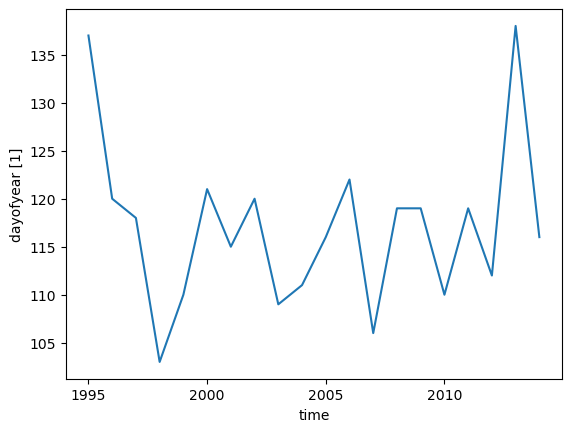

In [185]:
assign_decade(
    indices.frost_free_season_start(ref.sel(time=slice("1995", "2020")))
).plot()

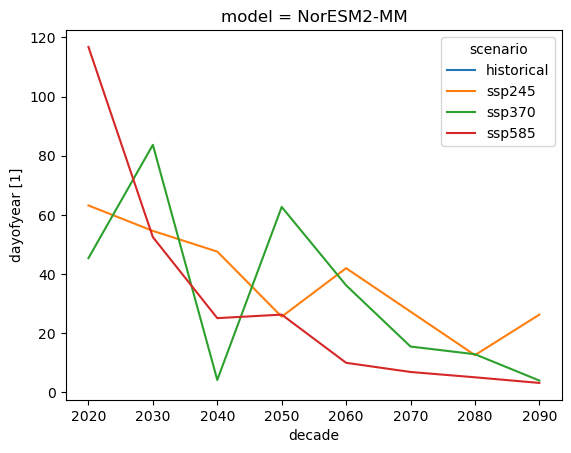

In [171]:
tmp.plot.line(x="decade", hue="scenario")

In [ ]:
ffss.groupby("decade").mean().plot(x="decade", hue="model", marker="scenario")

<xarray.DataArray 'dayofyear' (model: 4, scenario: 4, decade: 8)> Size: 1kB
array([[[  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
        [102. ,  86. ,  80.3,  92.1,  98.2,  83.8, 101.5,  66.6],
        [116.6, 114.8, 114.8,  67.9, 108.7,  53.4,   7.3,  17.5],
        [114.1, 114.8,  71.7,  36.5,   7.3,  13.8,   6.6,   2.7]],

       [[  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
        [109. , 105.3,  97.4,  99.7,  93.2,  98. , 100.7,  96.4],
        [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
        [108.3, 110.3, 108.5,  80.6,  96.1,  54.7,  48.2,  21.4]],

       [[  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
        [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
        [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
        [ 63.3,  45.8,  28.5,  35.7,  15.9,   3. ,   2.4,   1.1]],

       [[  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
        [ 63.2,  54.6,  47.6,  25.6,  42. ,  27.3,  12.6,  26.3],
        [ 45.4,  83.7,   4.2,  62.7,  36.2,  15.5,  12.9,   4. ],
        [116.8,  52.5,  25.1,  26.3,  10. ,   6.9,   5.1,   3.2]]])
Coordinates:
  * model     (model) <U15 240B 'CESM2' 'HadGEM3-GC31-LL' ... 'NorESM2-MM'
  * scenario  (scenario) <U10 160B 'historical' 'ssp245' 'ssp370' 'ssp585'
  * decade    (decade) object 64B '2020' '2030' '2040' ... '2070' '2080' '2090'
Attributes:
    units:         1
    is_dayofyear:  1
    calendar:      noleap

In [136]:
indices.frost_free_season_start(adj_ds.sel(time=slice("2020", "2100")).tsl).groupby(
    "decade"
).mean().plot()

KeyError: 'decade'

In [ ]:
year = sim_di["ssp245"]["adj"]["time"].dt.year
decade = ((year - year[0]) / 10).astype(int)

sim_di["ssp245"]["adj"] = sim_di["ssp245"]["adj"].assign_coords({"decade": decade})
sim_di["ssp585"]["adj"] = sim_di["ssp585"]["adj"].assign_coords({"decade": decade})

for scenario in ["ssp245", "ssp585"]:
    ffss = indices.frost_free_season_start(sim_di[scenario]["adj"])
    year = ffss["time"].dt.year
    decade = ((year - year[0]) / 10).astype(int)
    ffss.assign_coords({"decade": decade}).groupby("decade").mean("time").plot(
        label=scenario
    )


plt.legend()

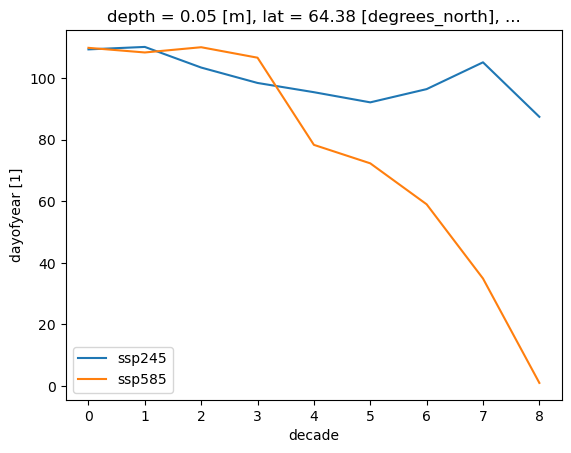

In [31]:
year = sim_di["ssp245"]["adj"]["time"].dt.year
decade = ((year - year[0]) / 10).astype(int)

sim_di["ssp245"]["adj"] = sim_di["ssp245"]["adj"].assign_coords({"decade": decade})
sim_di["ssp585"]["adj"] = sim_di["ssp585"]["adj"].assign_coords({"decade": decade})

for scenario in ["ssp245", "ssp585"]:
    ffss = indices.frost_free_season_start(sim_di[scenario]["adj"])
    year = ffss["time"].dt.year
    decade = ((year - year[0]) / 10).astype(int)
    ffss.assign_coords({"decade": decade}).groupby("decade").mean("time").plot(
        label=scenario
    )


plt.legend()

In [ ]:
tmp_ds.assign_coords({"model": "HadGEM3-GC31-LL", "scenario": "ssp245"}).expand_dims(
    ["model", "scenario"]
)

<xarray.DataArray 'scen' (model: 1, scenario: 1, time: 30430)> Size: 243kB
array([[[-6.1116458 , -6.6811458 , -7.10520829, ..., -0.96941667,
         -0.9588125 , -0.99062495]]])
Coordinates:
  * time      (time) object 243kB 2015-01-01 12:00:00 ... 2099-12-30 12:00:00
    depth     float64 8B 0.05
    lat       float64 8B 64.38
    lon       float64 8B 30.94
    decade    (time) int64 243kB 0 0 0 0 0 0 0 0 0 0 0 ... 8 8 8 8 8 8 8 8 8 8 8
  * model     (model) <U15 60B 'HadGEM3-GC31-LL'
  * scenario  (scenario) <U6 24B 'ssp245'
Attributes:
    standard_name:    soil_temperature
    long_name:        Temperature of Soil
    comment:          Temperature of soil. Reported as missing for grid cells...
    units:            degC
    original_name:    mo: (stash: m01s08i225, lbproc: 128)
    cell_methods:     area: mean where land time: mean
    cell_measures:    area: areacella
    history:          2019-09-06T15:21:24Z altered by CMOR: replaced missing ...
    units_metadata:   temperature: unknown
    bias_adjustment:  DetrendedQuantileMapping(group=Grouper(name='time.dayof...

In [ ]:
import xarray as xr

# Create a dataset from the data arrays in sim_di
ds = xr.Dataset(
    {
        f"{scenario}_{var}": (["time"], sim_di[scenario][var])
        for scenario in sim_di
        for var in sim_di[scenario]
    }
)

# Add coordinates for each dictionary level
ds = ds.assign_coords(
    {
        "scenario": list(sim_di.keys()),
        "variable": list(sim_di["ssp245"].keys()),
        "time": sim_di["ssp245"]["raw"]["time"],
        "depth": sim_di["ssp245"]["raw"]["depth"],
        "lat": sim_di["ssp245"]["raw"]["lat"],
        "lon": sim_di["ssp245"]["raw"]["lon"],
    }
)

ds

In [33]:
sim_di["ssp245"]["adj"].rename("tsl")

<xarray.DataArray 'tsl' (time: 30430)> Size: 243kB
array([-6.1116458 , -6.6811458 , -7.10520829, ..., -0.96941667,
       -0.9588125 , -0.99062495])
Coordinates:
  * time     (time) object 243kB 2015-01-01 12:00:00 ... 2099-12-30 12:00:00
    depth    float64 8B 0.05
    lat      float64 8B 64.38
    lon      float64 8B 30.94
    decade   (time) int64 243kB 0 0 0 0 0 0 0 0 0 0 0 ... 8 8 8 8 8 8 8 8 8 8 8
Attributes:
    standard_name:    soil_temperature
    long_name:        Temperature of Soil
    comment:          Temperature of soil. Reported as missing for grid cells...
    units:            degC
    original_name:    mo: (stash: m01s08i225, lbproc: 128)
    cell_methods:     area: mean where land time: mean
    cell_measures:    area: areacella
    history:          2019-09-06T15:21:24Z altered by CMOR: replaced missing ...
    units_metadata:   temperature: unknown
    bias_adjustment:  DetrendedQuantileMapping(group=Grouper(name='time.dayof...

In [ ]:
# links for PL data, not sure if I'll use

# urls are not consistent so just listing them all

urls = [
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_08.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/uf_09.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_10.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_11.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/uf_daily_2012.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_daily_2013.xls",
    "https://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_daily_2014.xls",
    "https://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_daily_2015.xls",
    "https://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_daily_2016.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_daily_2017.xls",
    "https://permafrost.gi.alaska.edu/sites/default/files/site_data/UF1_daily_2018.csv",
    "https://permafrost.gi.alaska.edu/sites/default/files/users/veromanovsky/US_UFF_102_2019-06-01_2020-05-31_daily.csv",
    "https://permafrost.gi.alaska.edu/sites/default/files/users/veromanovsky/US_UFF_102_2020-06-01_2021-05-31_daily.csv",
    "https://permafrost.gi.alaska.edu/sites/default/files/users/veromanovsky/US_UFF_102_2021-06-01_2022-04-23_daily.csv",
]

In [27]:
tmp = pd.read_excel(urls[0], header=13)

In [ ]:
tmp.rename(columns={"Unnamed: 4": "tas", "0.001": "tsk", 0.045	0.127	})

SyntaxError: ':' expected after dictionary key (2324805064.py, line 1)

In [52]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv(urls[-4], header=10)

In [53]:
df

,ALASKAN SUMMER TIME,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,DATE,Temp_107_Air,Temp_MRC_0.02m,Temp_MRC_0.10m,Temp_MRC_0.17m,Temp_MRC_0.25m,Temp_MRC_0.33m,Temp_MRC_0.40m,Temp_MRC_0.48m,Temp_MRC_0.56m,Temp_MRC_0.70m,Temp_MRC_0.86m,Temp_MRC_1.07m
1,2017-06-01,14.324,6.1522,4.0195,2.5516,1.6334,0.705,-0.0785,-0.1606,-0.1562,-0.1547,-0.1454,-0.1728
2,2017-06-02,15.81,7.2936,4.8476,3.1257,2.0514,1.0115,0.0851,-0.1579,-0.1592,-0.1562,-0.1486,-0.1727
3,2017-06-03,16.942,7.8056,5.3649,3.606,2.4655,1.3495,0.3675,-0.1537,-0.1573,-0.1573,-0.1475,-0.1724
4,2017-06-04,17.699,8.5503,5.9825,4.0995,2.872,1.6925,0.7284,-0.1354,-0.1581,-0.1577,-0.1496,-0.1707
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2018-05-28,12.383,5.1193,3.1943,1.7813,0.6568,-0.15,-0.1892,-0.182,-0.1815,-0.1833,-0.15,-0.0299
363,2018-05-29,13.455,5.821,3.668,2.085,0.901,-0.1353,-0.1907,-0.1795,-0.1786,-0.1768,-0.1519,-0.0318
364,2018-05-30,13.28,6.1637,3.9893,2.3726,1.1628,-0.0994,-0.189,-0.1791,-0.1751,-0.1721,-0.1538,-0.0333
365,2018-05-31,12.01,6.3305,4.2066,2.5901,1.391,0.0285,-0.1865,-0.1717,-0.1665,-0.1702,-0.1519,-0.0362
